### Shapefiles content

- .shp - shapefile - geometry
- .dbf - database - metadata
- .prj - projection
- .shx - index

In [3]:
#Import geopandas
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj
import pandas as pd
#import h5py    
import os
import numpy as np

In [4]:
dataset = gpd.read_file("/media/omar/storage/gdrive/Maestria/Datasets/Fronetra_Agricola_prueba/Frontera_agricola_prueba.shp")
# dataset.set_index("DeNombre", inplace=True)
# dataset.to_crs(pyproj.CRS.from_epsg(4326), inplace=True)
dataset.elemento = dataset.elemento.map(
    {
        "Frontera agrícola nacional": "National Agricultural Frontier",
        "Bosques naturales y áreas no agropecuarias": "Natural forest and non-agricultural areas",
        "Exclusiones legales": "Legal exclusions",
    }
)
dataset.head()

,fid,municipio,departamen,cod_depart,cod_dane_m,elemento,area_ha,consecutiv,shape_Leng,shape_Area,geometry
0,1.0,Briceño,Antioquia,05,05107,Natural forest and non-agricultural areas,1263.289795,53719.0,1.047167e+05,1.263290e+07,"POLYGON ((841492.092 1288046.756, 841492.092 1..."
1,2.0,Cáceres,Antioquia,05,05120,Natural forest and non-agricultural areas,122.002602,62378.0,3.542558e+04,1.220026e+06,"POLYGON ((852564.313 1345775.424, 852566.959 1..."
2,3.0,Cáceres,Antioquia,05,05120,Natural forest and non-agricultural areas,745.168152,62493.0,1.384858e+05,7.451682e+06,"POLYGON ((857403.491 1346907.203, 857413.162 1..."
3,4.0,Cáceres,Antioquia,05,05120,National Agricultural Frontier,107821.726563,62693.0,3.484956e+06,1.078217e+09,"POLYGON ((859645.832 1334045.666, 859645.832 1..."
4,5.0,Cáceres,Antioquia,05,05120,National Agricultural Frontier,858.102539,62699.0,7.235331e+04,8.581026e+06,"POLYGON ((859267.059 1339132.614, 859259.121 1..."


In [5]:
dataset.crs

<Projected CRS: EPSG:3116>
Name: MAGNA-SIRGAS / Colombia Bogota zone
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Colombia - onshore between 1°30'W and 1°30'E of Bogota (75°35'W and 72°35'W of Greenwich).
- bounds: (-75.59, -2.51, -72.58, 11.82)
Coordinate Operation:
- name: Colombia MAGNA Bogota zone
- method: Transverse Mercator
Datum: Marco Geocentrico Nacional de Referencia
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich



```
import plotly.express as px
fig = px.choropleth(dataset,
                   geojson=dataset.geometry,
                   locations=dataset.index,
                    color="OBJECTID", width  = 500, height=500)
fig.update_geos(fitbounds="locations", visible=False)
fig.show()
```



(716795.4251850002, 905685.2453149998, 1256255.483385, 1447540.348915)

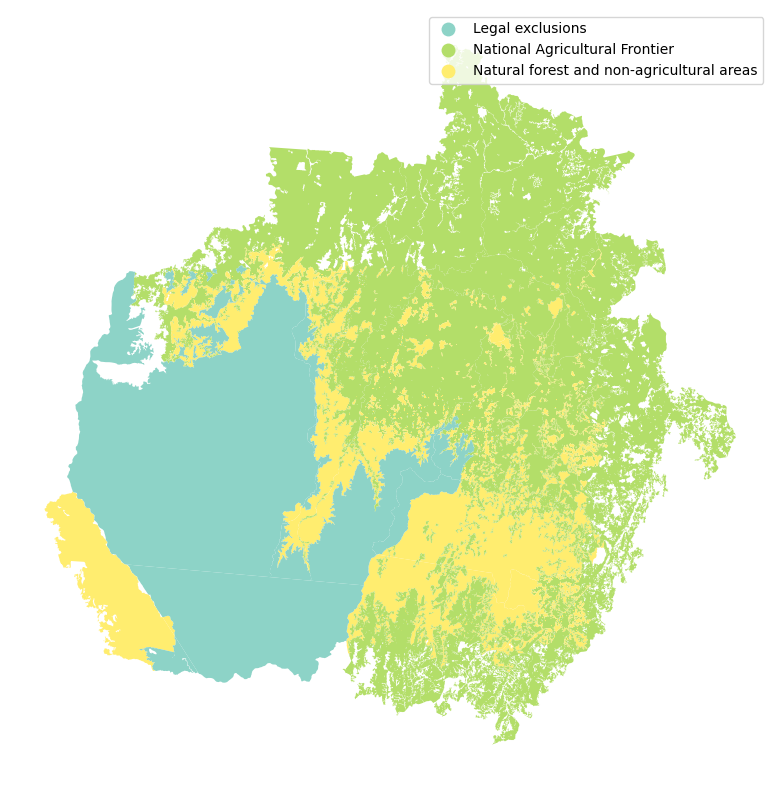

In [17]:
dataset.plot(figsize=(15,10), cmap="Set3", column="elemento", legend=True)
plt.axis("off")

In [6]:
#read hdf file
colombia_crop_chips = h5py.File("/content/drive/MyDrive/2021-MAESTRIA-OMAR-CASTAÑO/earth observation datasets/sentinel 2 - colombia north west 290GB/colombia_crop_chips.hdf")
np.array(colombia_crop_chips['data'])

array(['axis0', 'axis1', 'block0_items', 'block0_values', 'block1_items',
       'block1_values'], dtype='<U13')

## Loading chips

In [7]:
#Chip path
chip_path = '/content/drive/MyDrive/2021-MAESTRIA-OMAR-CASTAÑO/earth observation datasets/sentinel 2 - colombia north west 290GB/data/colombia/s2_data/01_L1_colombia__2019-01-01__2021-05-30/18NTN/18NTN_8_5/(0, 200)/'

In [8]:
#Read metadata
chip_metadata = pd.read_pickle(chip_path + 'metadata.pkl')
chip_metadata

{'center_latlon': array([  6.77726963, -76.968011  ]),
 'chip_id': '(0, 200)',
 'chip_size': 100,
 'corners': {'nw': array([  6.78180805, -76.97255079]),
  'se': array([  6.77273122, -76.9634712 ])},
 'grid_size': 10,
 'patch_id': '18NTN_8_5',
 'patch_size': 1000}

In [9]:
#Load chip
chip = np.load(chip_path + 'chip.npz')
chip.files

['arr_0']

In [10]:
#Chip shape
chip['arr_0'].shape

(24, 11, 100, 100)

In [11]:
chip['arr_0'].min()

23

In [12]:
chip['arr_0'].max()

9486

In [27]:
chip['arr_0'][:,0:3,:,:].max()

8912

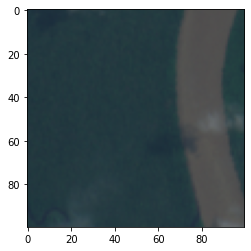

In [30]:
plt.imshow(chip['arr_0'][7][0:3].transpose(1,2,0)/4095)

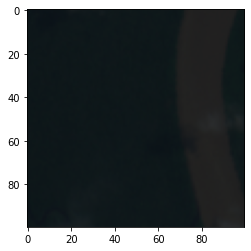

In [29]:
plt.imshow(chip['arr_0'][7][0:3].transpose(1,2,0)/10000)

In [13]:
#Load library to plot Earth observations
!pip install earthpy
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

     |████████████████████████████████| 1.4 MB 8.6 MB/s 
     |████████████████████████████████| 19.3 MB 396 kB/s 


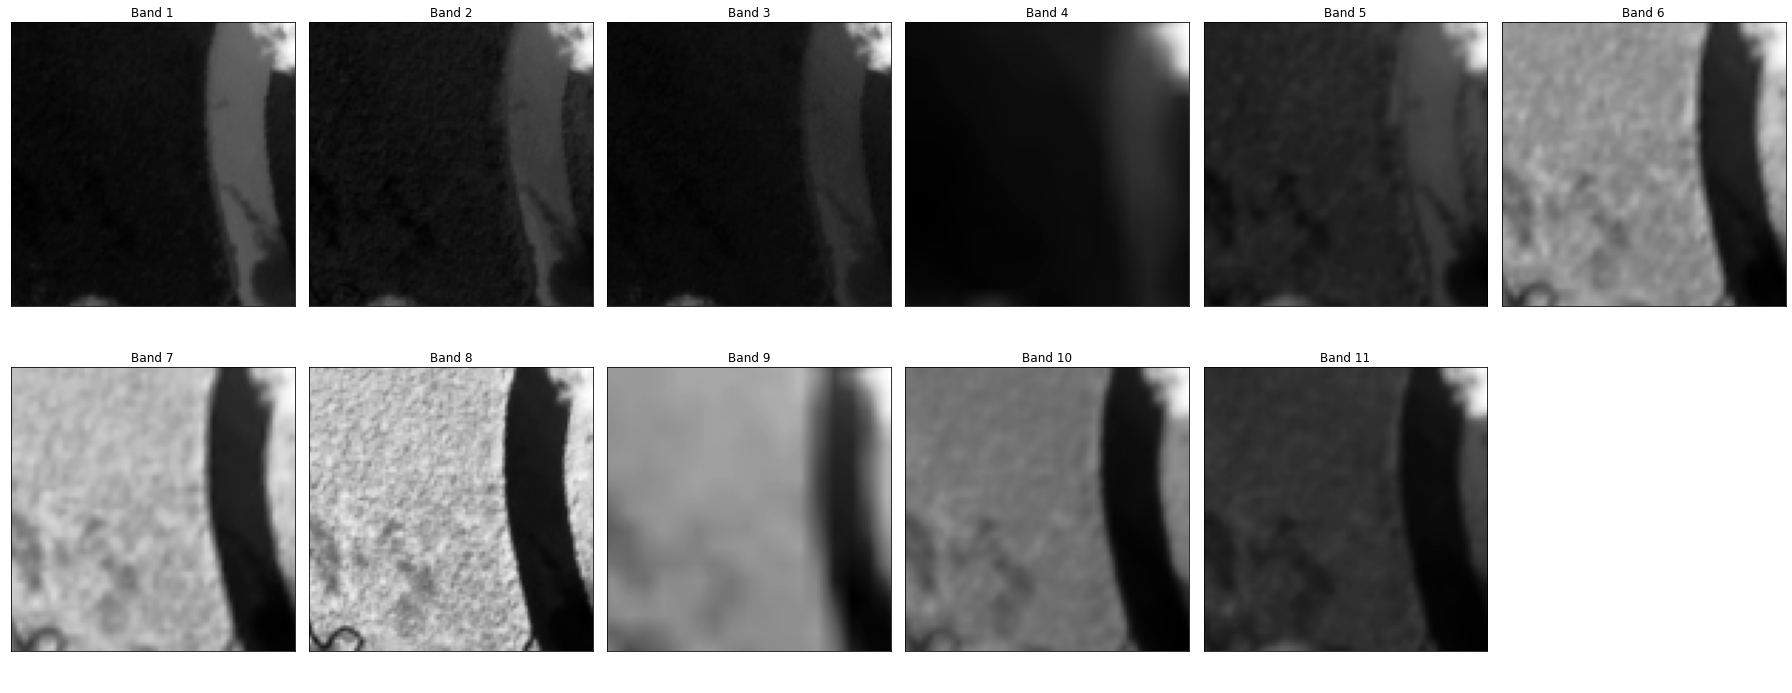

In [ ]:
#Plot chips
one_chip=chip['arr_0'][0]
ep.plot_bands(one_chip, cols=6, scale=True, cbar=False, figsize=(25,10));

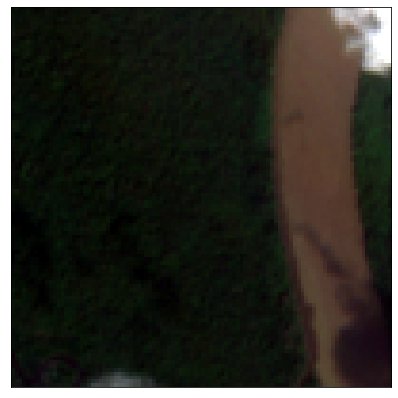

In [ ]:
#Plot rgb image
ep.plot_rgb(one_chip, rgb=(0,1,2), stretch=True, str_clip=0.5, figsize=(7, 7))

## Loading Time Stamps

In [ ]:
##load timestamp
timestamp = np.load(chip_path+'timestamps.npz')
timestamp.files

['arr_0']

In [ ]:
#Print timestamps
timestamp['arr_0']

array(['2019-01-12_15:41:20', '2019-02-16_15:41:17',
       '2019-03-13_15:41:18', '2019-04-27_15:41:24',
       '2019-05-17_15:41:24', '2019-06-01_15:41:29',
       '2019-07-01_15:41:29', '2019-08-10_15:41:27',
       '2019-09-09_15:41:23', '2019-10-09_15:41:21',
       '2019-11-23_15:41:21', '2019-12-08_15:41:15',
       '2020-01-07_15:41:15', '2020-02-11_15:41:13',
       '2020-03-02_15:41:16', '2020-04-16_15:41:16',
       '2020-05-31_15:41:27', '2020-06-20_15:41:26',
       '2020-07-15_15:41:22', '2020-08-04_15:41:24',
       '2020-09-18_15:41:25', '2020-10-08_15:41:26',
       '2020-11-27_15:41:21', '2020-12-02_15:41:20'], dtype='<U19')

# Create Shapefiel from latitud and longitud

In [ ]:
def create_shapefiel_from_polygons(path_to_chip_metadata:str, chip_name:str, path_to_save:str=None, crs:str='epsg:4326'):

    """
    Function that allow you to create a shapefile from chip corners cordinates.
    Args:
        path_to_chip_metadata: string
            path to the chip metadata file which muste 
            be in pickle format. 
        chip_name: string
            names associated with the chip
        path_to_save: string, optional (default=None)
             path to save the shapefile.
        crs: string, optional (default='epsg:4326')
            projection for the output shapefile
    """
    chip_metadata = pd.read_pickle(path_to_chip_metadata)

    #Defien coordinates
    nw = chip_metadata['corners']['nw'][::-1]
    se = chip_metadata['corners']['se'][::-1]
    ne = np.array([nw[0],  se[1]])
    sw = np.array([se[0],  nw[1]])
    
    nw = nw + np.sign(nw)*0.001
    #se = se + np.sign(se)*0.1
    #ne = ne + np.sign(ne)*0.1
    #sw = sw + np.sign(sw)*0.1

    coordinates = [sw, nw, ne, se]

    polygon = Polygon(coordinates)
    gdf = gpd.GeoDataFrame()
    gdf.loc[0,'chip'] = chip_name
    gdf.loc[0, 'geometry'] = polygon
    gdf.crs = 'epsg:4326'

    if crs != 'epsg:4326':
        gdf.to_crs(crs, inplace=True)

    if path_to_save:
        gdf.to_file(path_to_save)
    return gdf

In [ ]:
!git clone https://github.com/omarcastano/MasterThesis.git

fatal: destination path 'MasterThesis' already exists and is not an empty directory.


In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon
import folium
import MasterThesis.DataPreprocessing as DP

In [ ]:
#Read metadata
chip_metadata = pd.read_pickle(chip_path + 'metadata.pkl')
chip_metadata

{'center_latlon': array([  6.77726963, -76.968011  ]),
 'chip_id': '(0, 200)',
 'chip_size': 100,
 'corners': {'nw': array([  6.78180805, -76.97255079]),
  'se': array([  6.77273122, -76.9634712 ])},
 'grid_size': 10,
 'patch_id': '18NTN_8_5',
 'patch_size': 1000}

In [ ]:
#Defien coordinates
nw = chip_metadata['corners']['nw'][::-1]
se = chip_metadata['corners']['se'][::-1]
ne = np.array([nw[0],  se[1]])
sw = np.array([se[0],  nw[1]])
coordinates = [sw, nw, ne, se]
coordinates

[array([-76.9634712 ,   6.78180805]),
 array([-76.97255079,   6.78180805]),
 array([-76.97255079,   6.77273122]),
 array([-76.9634712 ,   6.77273122])]

In [ ]:
path_to_save = '/content/drive/MyDrive/Colab Notebooks/Maestria Ing/Theses/GeoDataset/Chip/18NTN.shp'
chip_metadata_path = chip_path + 'metadata.pkl'
shapefile = create_shapefiel_from_polygons(chip_metadata_path, chip_name = '18NTN_8_5_(0_200)', path_to_save=path_to_save, crs='epsg:3116')
shapefile = gpd.read_file(path_to_save)

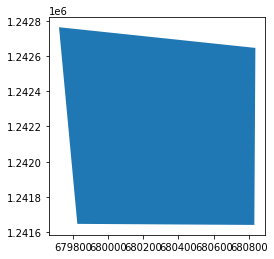

In [ ]:
shapefile.plot()

# Intersection

In [ ]:
def polygons_intersection(shapefile1, shapefile2, chip_name=None, group_by='elemento' ,path_to_save=None , crs=None):

    """
    Functon that conputes the intesection between polygons stored in shapefiles.
    shapefile1: string or geo pandas dataframe
        either the path to the folder where a shapefile is stored or
        a geopandas dataframe with the polygons. Here you must provide 
        the "Fronteer".
    shapefile2: string or geo pandas dataframe
        either the path to the folder where a shapefile is stored or
        a geopandas dataframe with the polygons. Here you must provide the 
        squared polygons.
    chip_name: string:
        unique id for each chip.
    group_by: string.
        column name from the attribute table of shapefiel1 which will be used to create 
        class labels.
    path_to_save: string, optional (default=None)
        path to the folder where the shapefile which contains the 
        intersection will be stored
    crs: string, optional (default=None)
        Projection for the output shapefile. If None the output projection
        will be the same of input shapefiles.
    """

    if type(shapefile1) == str:
        shapefile1 = gpd.read_file(shapefile1)

    if type(shapefile2) == str:
        shapefile2 = gpd.read_file(shapefile2)

    unique_labels = shapefile1[group_by].unique()
    unique_labels.sort()
    
    label_num = np.arange(len(unique_labels))


    chip_references=[]
    geometry = []
    labels = []
    for label in unique_labels:
        data = []
        chip_references.append(chip_name)
        sipra_mask = shapefile1.loc[shapefile1[group_by] == label, :]
        for indx1, info1 in sipra_mask.iterrows():
            for indx2, info2 in shapefile2.iterrows():
                inter = info2['geometry'].intersection(info1['geometry'])
                data.append([inter])


        intersection = gpd.GeoDataFrame(data, columns=['geometry'], crs = shapefile1.crs)
        intersection = gpd.GeoDataFrame(intersection.dissolve(), columns=['geometry'], crs = shapefile1.crs)

        labels.append(label)
        geometry.append(intersection.geometry.values[0])

    
    intersection = gpd.GeoDataFrame({"chip_name":chip_references,"labels":labels,"labels_num":label_num ,"geometry":geometry}, crs = shapefile1.crs)

    if (crs != shapefile1.crs) & (crs != None):
        intersection.to_crs(crs, inplace=True)

    if path_to_save:
        intersection.to_file(path_to_save)

    return intersection

In [ ]:
#Read dataset
path_to_shp = '/content/drive/MyDrive/Colab Notebooks/Maestria Ing/Theses/Frontera_Agricola_Nov2021/Frontera_Agricola_Nov2021.shp'
path_to_shp = '/content/drive/MyDrive/Colab Notebooks/Maestria Ing/Theses/GeoDataset/Frontera_Agricola_Prueba/Frontera_Agricola_Prueba.shp'
dataset = gpd.read_file(path_to_shp)

In [ ]:
#show dataset
dataset.head()

,municipio,departamen,cod_depart,cod_dane_m,elemento,area_ha,consecutiv,shape_Leng,shape_Area,geometry
0,Bojayá (Bellavista),Chocó,27,27099,Frontera agrícola nacional,1488.495483,50828,246062.311094,1.488495e+07,"POLYGON ((678937.790 1206459.215, 678968.507 1..."
1,Murindó,Antioquia,05,05475,Frontera agrícola nacional,5793.554688,263751,199426.465557,5.793555e+07,"POLYGON ((692791.151 1242713.619, 692791.151 1..."
2,Vigía del Fuerte,Antioquia,05,05873,Bosques naturales y áreas no agropecuarias,128114.742188,536350,839140.189397,1.281147e+09,"POLYGON ((707566.023 1180675.615, 707566.023 1..."
3,Vigía del Fuerte,Antioquia,05,05873,Frontera agrícola nacional,712.337463,536409,102707.341969,7.123375e+06,"POLYGON ((702251.984 1187696.502, 702251.984 1..."
4,Vigía del Fuerte,Antioquia,05,05873,Frontera agrícola nacional,4137.225586,536441,342534.237677,4.137225e+07,"POLYGON ((684098.244 1228282.169, 684098.244 1..."


In [ ]:
#unique classes
#dataset.elemento.unique()

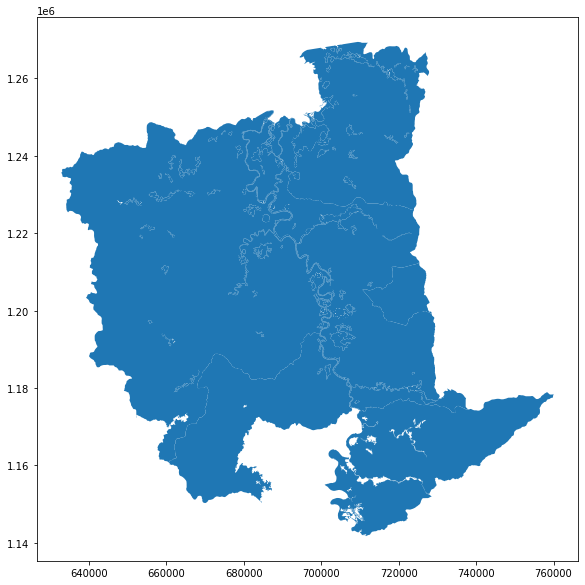

In [ ]:
dataset.plot(figsize=(15,10))

In [ ]:
#projection
dataset.crs

<Projected CRS: EPSG:3116>
Name: MAGNA-SIRGAS / Colombia Bogota zone
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Colombia - onshore between 1°30'W and 1°30'E of Bogota (75°35'W and 72°35'W of Greenwich).
- bounds: (-75.59, -2.51, -72.58, 11.82)
Coordinate Operation:
- name: Colombia MAGNA Bogota zone
- method: Transverse Mercator
Datum: Marco Geocentrico Nacional de Referencia
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
#dataset.to_crs('epsg:4326', inplace=True)
#dataset.crs

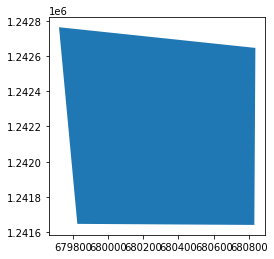

In [ ]:
shapefile.plot()

In [ ]:
dataset

,municipio,departamen,cod_depart,cod_dane_m,elemento,area_ha,consecutiv,shape_Leng,shape_Area,geometry
0,Bojayá (Bellavista),Chocó,27,27099,Frontera agrícola nacional,1488.495483,50828,246062.311094,1.488495e+07,"POLYGON ((678937.790 1206459.215, 678968.507 1..."
1,Murindó,Antioquia,05,05475,Frontera agrícola nacional,5793.554688,263751,199426.465557,5.793555e+07,"POLYGON ((692791.151 1242713.619, 692791.151 1..."
2,Vigía del Fuerte,Antioquia,05,05873,Bosques naturales y áreas no agropecuarias,128114.742188,536350,839140.189397,1.281147e+09,"POLYGON ((707566.023 1180675.615, 707566.023 1..."
3,Vigía del Fuerte,Antioquia,05,05873,Frontera agrícola nacional,712.337463,536409,102707.341969,7.123375e+06,"POLYGON ((702251.984 1187696.502, 702251.984 1..."
4,Vigía del Fuerte,Antioquia,05,05873,Frontera agrícola nacional,4137.225586,536441,342534.237677,4.137225e+07,"POLYGON ((684098.244 1228282.169, 684098.244 1..."
...,...,...,...,...,...,...,...,...,...,...
453,Vigía del Fuerte,Antioquia,05,05873,Frontera agrícola nacional,85.055748,536438,8234.495300,8.505575e+05,"POLYGON ((690855.981 1227067.937, 690825.264 1..."
454,Vigía del Fuerte,Antioquia,05,05873,Frontera agrícola nacional,113.164673,536447,23878.726772,1.131647e+06,"POLYGON ((680995.828 1241205.227, 680995.828 1..."
455,Vigía del Fuerte,Antioquia,05,05873,Frontera agrícola nacional,419.065125,536448,11974.161491,4.190651e+06,"POLYGON ((683694.030 1242174.152, 683796.836 1..."
456,Vigía del Fuerte,Antioquia,05,05873,Frontera agrícola nacional,431.778198,536449,22564.097598,4.317782e+06,"POLYGON ((685377.210 1243199.337, 685391.606 1..."


In [ ]:
path_to_save = '/content/drive/MyDrive/Colab Notebooks/Maestria Ing/Theses/GeoDataset/Intersection/Intersection.shp'
path_shapefiel1 = '/content/drive/MyDrive/Colab Notebooks/Maestria Ing/Theses/GeoDataset/Frontera_Agricola_Prueba/Frontera_Agricola_Prueba.shp'
path_shapefiel2 = '/content/drive/MyDrive/Colab Notebooks/Maestria Ing/Theses/GeoDataset/Chip/18NTN.shp'
intersection = polygons_intersection(path_shapefiel1, path_shapefiel2, "chip", crs='epsg:3116')
intersection

,chip_name,labels,labels_num,geometry
0,chip,Bosques naturales y áreas no agropecuarias,0,"MULTIPOLYGON (((680825.730 1241716.037, 680797..."
1,chip,Exclusiones legales,1,GEOMETRYCOLLECTION EMPTY
2,chip,Frontera agrícola nacional,2,"POLYGON ((680623.188 1241642.113, 680618.057 1..."


epsg:3116


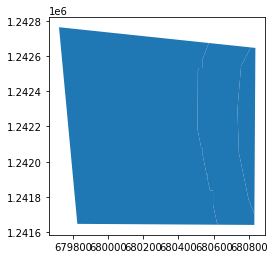

In [ ]:
print(intersection.crs)
intersection.plot()

# Create GeoTiff from Numpy array

In [ ]:
#Import libraries
from osgeo import osr, gdal, ogr

In [ ]:
#image
one_chip.shape

(11, 100, 100)

In [ ]:
#Metadata
chip_metadata

{'center_latlon': array([  6.77726963, -76.968011  ]),
 'chip_id': '(0, 200)',
 'chip_size': 100,
 'corners': {'nw': array([  6.78180805, -76.97255079]),
  'se': array([  6.77273122, -76.9634712 ])},
 'grid_size': 10,
 'patch_id': '18NTN_8_5',
 'patch_size': 1000}

In [ ]:
path_to_save = '/content/drive/MyDrive/Colab Notebooks/Maestria Ing/Theses/GeoDataset/GeoTiff/raster.tif'
array = one_chip[0:3]
DP.from_array_to_geotiff(path_to_save, array, chip_metadata)

In [ ]:
#open geotiff image
raster_image = gdal.Open(path_to_save)
gt = raster_image.GetGeoTransform()
gt

(679831.9470280777, 10.0, 0.0, 1242651.9199160547, 0.0, -10.0)

In [ ]:
raster_image.GetProjection()

'PROJCS["MAGNA-SIRGAS / Colombia Bogota zone",GEOGCS["MAGNA-SIRGAS",DATUM["Marco_Geocentrico_Nacional_de_Referencia",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6686"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4686"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",4.596200416666666],PARAMETER["central_meridian",-74.07750791666666],PARAMETER["scale_factor",1],PARAMETER["false_easting",1000000],PARAMETER["false_northing",1000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","3116"]]'

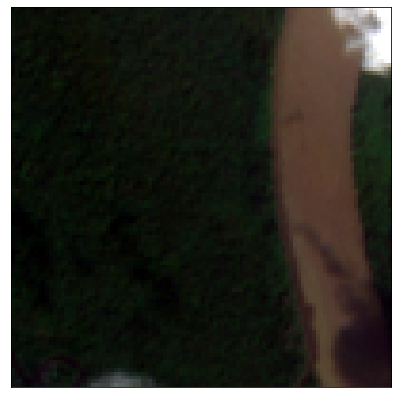

In [ ]:
#open geotiff image
raster_image = gdal.Open(path_to_save).ReadAsArray()
raster_image.shape
ep.plot_rgb(raster_image, rgb=(0,1,2), stretch=True, str_clip=0.5, figsize=(7, 7))